Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
rcParams["savefig.bbox"] = 'tight'
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10. # 35 #0.107
tauc = 20.

cearth = 35.
tauc   = 6603.

coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(201, 26, 46)

In [4]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

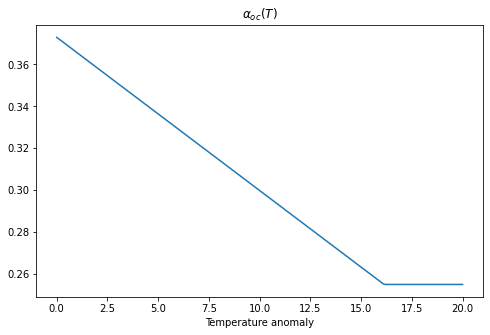

(0.255, 0.372950625)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

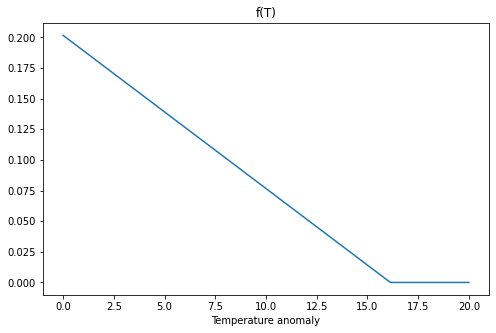

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [7]:
frac_sea_ice.mean()

0.08140298507462679

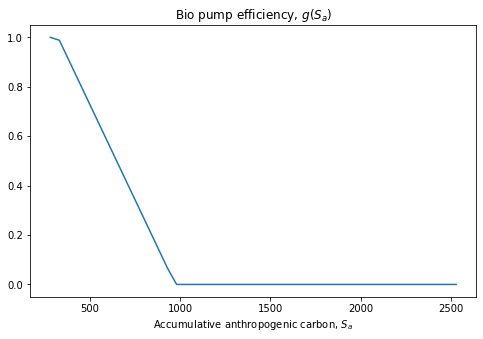

In [8]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

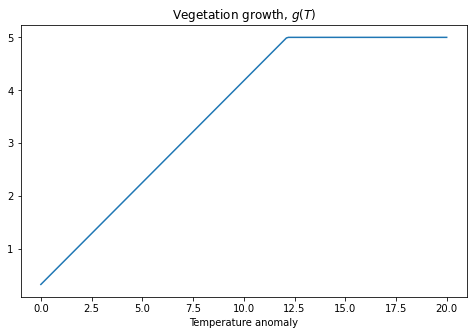

(0.33461538461538637, 5.0)

In [9]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [10]:
vege_growth.mean()

3.5806352851128977

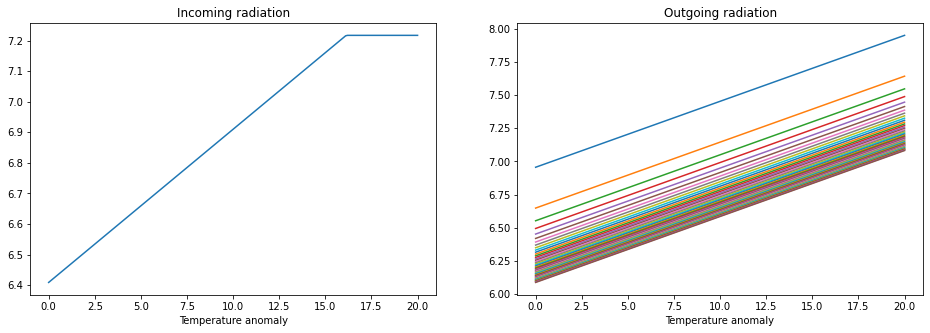

In [11]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

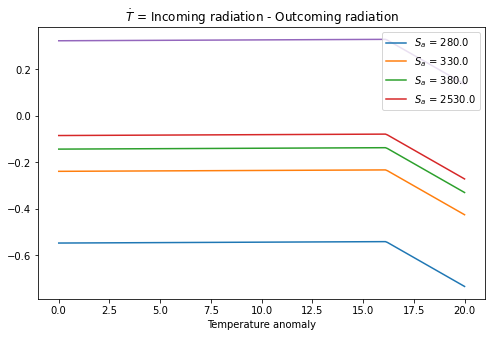

In [12]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [13]:
T_grid[5], F_grid[17], C_grid[1]

(0.5, 1130.0, 260)

In [14]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.17366649657357502, 0.018600000000000002)

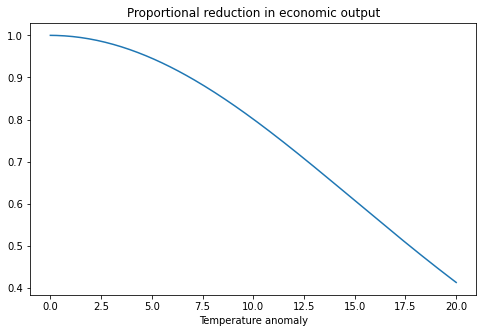

In [15]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [343]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 1e-8 
T_max  = 10. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 200.
C_max  = 400.
hC     = 10.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton, since 1800
F_min = 0. # 10. avaoid 
F_max = 300. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 10.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(51, 21, 31)

In [345]:
cearth = 1.053 * 8
tauc   = 200.


# v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.05
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.05


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.025366089896359245;	 PDE Error: 0.02602046347029209	
Iteration: 2;	 False Transient Error: 0.025280270363103874;	 PDE Error: 0.02598390525255241	
Iteration: 3;	 False Transient Error: 0.02519483868484773;	 PDE Error: 0.025947469571295657	
Iteration: 4;	 False Transient Error: 0.06688507631466001;	 PDE Error: 0.02591116261922148	
Iteration: 5;	 False Transient Error: 0.04161587553122126;	 PDE Error: 0.02587498942723416	
Iteration: 6;	 False Transient Error: 0.027645132051469234;	 PDE Error: 0.02583895411462467	
Iteration: 7;	 False Transient Error: 0.024856976936522557;	 PDE Error: 0.025803060011503856	
Iteration: 8;	 False Transient Error: 0.024773464711920212;	 PDE Error: 0.02576730978575062	
Iteration: 9;	 False Transient Error: 0.024690330104648606;	 PDE Error: 0.02573170550203692	
Iteration: 10;	 False Transient Error: 0.024607571804533546;	 PDE Error: 0.025696248461288672	
Iteration: 11;	 False Transient Error: 0.024525187577688623;	 PDE Err

Iteration: 90;	 False Transient Error: 0.03386550479696826;	 PDE Error: 0.06343343552699728	
Iteration: 91;	 False Transient Error: 0.03332922606643862;	 PDE Error: 0.06106477893148847	
Iteration: 92;	 False Transient Error: 0.03254390581844735;	 PDE Error: 0.05875276955105607	
Iteration: 93;	 False Transient Error: 0.031646202544377555;	 PDE Error: 0.056498161166134195	
Iteration: 94;	 False Transient Error: 0.030688021646461117;	 PDE Error: 0.05430149646436861	
Iteration: 95;	 False Transient Error: 0.029696452131044992;	 PDE Error: 0.05216313406179375	
Iteration: 96;	 False Transient Error: 0.02868812631123152;	 PDE Error: 0.05008327271649553	
Iteration: 97;	 False Transient Error: 0.02767424616271441;	 PDE Error: 0.048061980787329366	
Iteration: 98;	 False Transient Error: 0.04614234042326526;	 PDE Error: 0.04609922765990244	
Iteration: 99;	 False Transient Error: 0.02608661870592721;	 PDE Error: 0.04419492697930149	
Iteration: 100;	 False Transient Error: 0.026108289587849498;	 PD

Iteration: 181;	 False Transient Error: 0.05129940660929755;	 PDE Error: 0.05130429892806494	
Iteration: 182;	 False Transient Error: 0.05170117587751655;	 PDE Error: 0.051715980506913346	
Iteration: 183;	 False Transient Error: 0.052098052729097066;	 PDE Error: 0.052122700243090875	
Iteration: 184;	 False Transient Error: 0.052490173396362305;	 PDE Error: 0.05252458240412346	
Iteration: 185;	 False Transient Error: 0.05287766742095634;	 PDE Error: 0.052921746032347575	
Iteration: 186;	 False Transient Error: 0.05480821872706043;	 PDE Error: 0.05331430511120065	
Iteration: 187;	 False Transient Error: 0.058855211947073105;	 PDE Error: 0.05370238216215459	
Iteration: 188;	 False Transient Error: 0.056212460260820496;	 PDE Error: 0.054086084212611324	
Iteration: 189;	 False Transient Error: 0.054383453717241625;	 PDE Error: 0.05446551313336485	
Iteration: 190;	 False Transient Error: 0.05474935551084803;	 PDE Error: 0.0548407665534676	
Iteration: 191;	 False Transient Error: 0.0551112467

Iteration: 270;	 False Transient Error: 0.0805255008517225;	 PDE Error: 0.08114898599814173	
Iteration: 271;	 False Transient Error: 0.08084254213560627;	 PDE Error: 0.08147260157680006	
Iteration: 272;	 False Transient Error: 0.08115959387421601;	 PDE Error: 0.08179623740750044	
Iteration: 273;	 False Transient Error: 0.0814766569615255;	 PDE Error: 0.08211989452884405	
Iteration: 274;	 False Transient Error: 0.13334876182768962;	 PDE Error: 0.08244357393751184	
Iteration: 275;	 False Transient Error: 0.1387674899386182;	 PDE Error: 0.08276727646586646	
Iteration: 276;	 False Transient Error: 0.13297841867905724;	 PDE Error: 0.08309100317055382	
Iteration: 277;	 False Transient Error: 0.12399642058410265;	 PDE Error: 0.08341475495483441	
Iteration: 278;	 False Transient Error: 0.11410732433766002;	 PDE Error: 0.0837385326487978	
Iteration: 279;	 False Transient Error: 0.10421881285627821;	 PDE Error: 0.08406233708282757	
Iteration: 280;	 False Transient Error: 0.09473408149978768;	 PD

Iteration: 360;	 False Transient Error: 0.10915932507828963;	 PDE Error: 0.11041078772910662	
Iteration: 361;	 False Transient Error: 0.10947873173169587;	 PDE Error: 0.1107375626505061	
Iteration: 362;	 False Transient Error: 0.10979815507370372;	 PDE Error: 0.11106436638594219	
Iteration: 363;	 False Transient Error: 0.11011759021283041;	 PDE Error: 0.11139119835510414	
Iteration: 364;	 False Transient Error: 0.11043704621010342;	 PDE Error: 0.11171805798774273	
Iteration: 365;	 False Transient Error: 0.11075652468067965;	 PDE Error: 0.11204494473645643	
Iteration: 366;	 False Transient Error: 0.11107603365156038;	 PDE Error: 0.11237185814266343	
Iteration: 367;	 False Transient Error: 0.11139554119571127;	 PDE Error: 0.11269879775629976	
Iteration: 368;	 False Transient Error: 0.11171509033824023;	 PDE Error: 0.11302576281716939	
Iteration: 369;	 False Transient Error: 0.11419626201773392;	 PDE Error: 0.11335275301201439	
Iteration: 370;	 False Transient Error: 0.11235421546988533;	

Iteration: 453;	 False Transient Error: 0.13886159059250502;	 PDE Error: 0.15650147606174528	
Iteration: 454;	 False Transient Error: 0.13917966261086434;	 PDE Error: 0.1575823775534372	
Iteration: 455;	 False Transient Error: 0.13949765737735653;	 PDE Error: 0.15857436209318415	
Iteration: 456;	 False Transient Error: 0.13981559224528262;	 PDE Error: 0.15948421993546633	
Iteration: 457;	 False Transient Error: 0.14013346259288184;	 PDE Error: 0.16031808464479178	
Iteration: 458;	 False Transient Error: 0.14045127623814935;	 PDE Error: 0.1610815111274968	
Iteration: 459;	 False Transient Error: 0.1407690087039981;	 PDE Error: 0.1617795434545628	
Iteration: 460;	 False Transient Error: 0.14108667872267944;	 PDE Error: 0.16241677287437542	
Iteration: 461;	 False Transient Error: 0.14140427778223774;	 PDE Error: 0.16299738980898493	
Iteration: 462;	 False Transient Error: 0.14172180554938407;	 PDE Error: 0.16352522791588509	
Iteration: 463;	 False Transient Error: 0.1420392391160874;	 PDE

Iteration: 546;	 False Transient Error: 0.16799681204454409;	 PDE Error: 0.17074592046335807	
Iteration: 547;	 False Transient Error: 0.1683030188657142;	 PDE Error: 0.17106078925601276	
Iteration: 548;	 False Transient Error: 0.16860902032814096;	 PDE Error: 0.17137546185585636	
Iteration: 549;	 False Transient Error: 0.16891481213718862;	 PDE Error: 0.17168993649040726	
Iteration: 550;	 False Transient Error: 0.16922040642495695;	 PDE Error: 0.17200421126397558	
Iteration: 551;	 False Transient Error: 0.16952579150555813;	 PDE Error: 0.17231828465953108	
Iteration: 552;	 False Transient Error: 0.16983097723148433;	 PDE Error: 0.17263215488047778	
Iteration: 553;	 False Transient Error: 0.17013593547098083;	 PDE Error: 0.17294582023863989	
Iteration: 554;	 False Transient Error: 0.1704406867555086;	 PDE Error: 0.1732592787959783	
Iteration: 555;	 False Transient Error: 0.1707452242066232;	 PDE Error: 0.17357252887433042	
Iteration: 556;	 False Transient Error: 0.17104954616604218;	 PD

Iteration: 638;	 False Transient Error: 0.19509417523596362;	 PDE Error: 0.1986638024571833	
Iteration: 639;	 False Transient Error: 0.19537411033668128;	 PDE Error: 0.1989528953268101	
Iteration: 640;	 False Transient Error: 0.1956536683587462;	 PDE Error: 0.19924161819151417	
Iteration: 641;	 False Transient Error: 0.1959328478672706;	 PDE Error: 0.1995299690109469	
Iteration: 642;	 False Transient Error: 0.19621164738058638;	 PDE Error: 0.1998179457559118	
Iteration: 643;	 False Transient Error: 0.19649006511548883;	 PDE Error: 0.20010554640515615	
Iteration: 644;	 False Transient Error: 0.1967680984137843;	 PDE Error: 0.2003927689368757	
Iteration: 645;	 False Transient Error: 0.19704574810450737;	 PDE Error: 0.20067961128802744	
Iteration: 646;	 False Transient Error: 0.19732301130374275;	 PDE Error: 0.20096607151618923	
Iteration: 647;	 False Transient Error: 0.19759988533181172;	 PDE Error: 0.20125214760140211	
Iteration: 648;	 False Transient Error: 0.197876382386859;	 PDE Erro

Iteration: 728;	 False Transient Error: 0.21854769893378645;	 PDE Error: 0.6603877512693586	
Iteration: 729;	 False Transient Error: 0.21878572568692078;	 PDE Error: 0.6351575768923878	
Iteration: 730;	 False Transient Error: 0.21902320618574223;	 PDE Error: 0.6107979338447627	
Iteration: 731;	 False Transient Error: 0.21926010782898686;	 PDE Error: 0.5872853257663296	
Iteration: 732;	 False Transient Error: 0.2194964459253157;	 PDE Error: 0.5645964193960024	
Iteration: 733;	 False Transient Error: 0.219732226154008;	 PDE Error: 0.5427080857637638	
Iteration: 734;	 False Transient Error: 0.2199674371503768;	 PDE Error: 0.5215974394582927	
Iteration: 735;	 False Transient Error: 0.22020206146235566;	 PDE Error: 0.5012418706730097	
Iteration: 736;	 False Transient Error: 0.22043614257274413;	 PDE Error: 0.4816190752043453	
Iteration: 737;	 False Transient Error: 0.22066964312672965;	 PDE Error: 0.46270708115837234	
Iteration: 738;	 False Transient Error: 0.2209025657510466;	 PDE Error: 0

Iteration: 817;	 False Transient Error: 0.23730868580850384;	 PDE Error: 0.648798509181464	
Iteration: 818;	 False Transient Error: 0.476850606455943;	 PDE Error: 0.6621020109922761	
Iteration: 819;	 False Transient Error: 0.40262667838450783;	 PDE Error: 0.6737912914161168	
Iteration: 820;	 False Transient Error: 0.34014645236670527;	 PDE Error: 0.6838793107088098	
Iteration: 821;	 False Transient Error: 0.28842614692199176;	 PDE Error: 0.6923939413640762	
Iteration: 822;	 False Transient Error: 0.24568499604186833;	 PDE Error: 0.699374864249327	
Iteration: 823;	 False Transient Error: 0.23988826837595845;	 PDE Error: 0.7048709457682403	
Iteration: 824;	 False Transient Error: 0.24033265072846532;	 PDE Error: 0.7089380005096849	
Iteration: 825;	 False Transient Error: 0.24077629749132967;	 PDE Error: 0.7116368739259494	
Iteration: 826;	 False Transient Error: 0.24121922343173452;	 PDE Error: 0.7130317888980043	
Iteration: 827;	 False Transient Error: 0.24166141605972413;	 PDE Error: 0

Iteration: 908;	 False Transient Error: 0.27474404062029834;	 PDE Error: 0.27451756769904206	
Iteration: 909;	 False Transient Error: 0.2751149028688893;	 PDE Error: 0.2749157668929342	
Iteration: 910;	 False Transient Error: 4.085012944998687;	 PDE Error: 0.27531291260463586	
Iteration: 911;	 False Transient Error: 0.8158900412817327;	 PDE Error: 0.275709001862612	
Iteration: 912;	 False Transient Error: 0.27622145109699403;	 PDE Error: 0.3011712522891631	
Iteration: 913;	 False Transient Error: 0.2765882754934168;	 PDE Error: 0.43764530715679417	
Iteration: 914;	 False Transient Error: 0.2769540837110007;	 PDE Error: 0.5567148761201567	
Iteration: 915;	 False Transient Error: 0.27731887319319526;	 PDE Error: 0.6589026384593963	
Iteration: 916;	 False Transient Error: 0.2776826290842571;	 PDE Error: 0.7454621468872529	
Iteration: 917;	 False Transient Error: 0.3736933278404586;	 PDE Error: 0.8177379065460857	
Iteration: 918;	 False Transient Error: 0.27840705987259184;	 PDE Error: 0.8

Iteration: 1002;	 False Transient Error: 0.3052903501545412;	 PDE Error: 0.306935560214027	
Iteration: 1003;	 False Transient Error: 0.30595992543893225;	 PDE Error: 0.3072216799644618	
Iteration: 1004;	 False Transient Error: 1.0430322112324164;	 PDE Error: 0.30750647632373457	
Iteration: 1005;	 False Transient Error: 0.47534977151192925;	 PDE Error: 0.5289816134271298	
Iteration: 1006;	 False Transient Error: 0.30795955763471383;	 PDE Error: 0.7403515285003146	
Iteration: 1007;	 False Transient Error: 0.308623035058897;	 PDE Error: 0.8120361485426797	
Iteration: 1008;	 False Transient Error: 0.3092849762637151;	 PDE Error: 0.823318646574747	
Iteration: 1009;	 False Transient Error: 0.30994536516470994;	 PDE Error: 0.8083879727499892	
Iteration: 1010;	 False Transient Error: 0.3106042028037326;	 PDE Error: 0.782317866183408	
Iteration: 1011;	 False Transient Error: 0.311261478735414;	 PDE Error: 0.7518980477454489	
Iteration: 1012;	 False Transient Error: 0.3119171866941084;	 PDE Erro

Iteration: 1090;	 False Transient Error: 0.47866971964259486;	 PDE Error: 0.4783441797629325	
Iteration: 1091;	 False Transient Error: 0.720102812676735;	 PDE Error: 0.4796258585856772	
Iteration: 1092;	 False Transient Error: 0.5457451663668089;	 PDE Error: 0.4807375625820188	
Iteration: 1093;	 False Transient Error: 0.4815468116925903;	 PDE Error: 0.4816811549814018	
Iteration: 1094;	 False Transient Error: 0.4821746690184159;	 PDE Error: 0.48245865471504534	
Iteration: 1095;	 False Transient Error: 0.48264064739126367;	 PDE Error: 0.48307222739289285	
Iteration: 1096;	 False Transient Error: 0.4829471831038612;	 PDE Error: 0.4835241738820664	
Iteration: 1097;	 False Transient Error: 0.48309681102306934;	 PDE Error: 0.48381692022585177	
Iteration: 1098;	 False Transient Error: 0.4830921764224594;	 PDE Error: 0.4839530088081401	
Iteration: 1099;	 False Transient Error: 0.48293602885069564;	 PDE Error: 0.48393508814915503	
Iteration: 1100;	 False Transient Error: 0.4826312014268974;	 P

Iteration: 1184;	 False Transient Error: 0.4008287202301908;	 PDE Error: 0.4007323533951754	
Iteration: 1185;	 False Transient Error: 0.4016397110347114;	 PDE Error: 0.40109023880825306	
Iteration: 1186;	 False Transient Error: 0.40244819169918955;	 PDE Error: 0.40144561883213836	
Iteration: 1187;	 False Transient Error: 0.40325416415820214;	 PDE Error: 0.4017984898722224	
Iteration: 1188;	 False Transient Error: 0.40405760614554254;	 PDE Error: 0.40214884892332947	
Iteration: 1189;	 False Transient Error: 0.40485851630750247;	 PDE Error: 0.40249669257621284	
Iteration: 1190;	 False Transient Error: 0.4056568915167702;	 PDE Error: 0.4028420177987744	
Iteration: 1191;	 False Transient Error: 0.40645270123659927;	 PDE Error: 0.4031848219043198	
Iteration: 1192;	 False Transient Error: 0.4072459334361156;	 PDE Error: 0.4035251014234533	
Iteration: 1193;	 False Transient Error: 0.4080365960460419;	 PDE Error: 0.4038628528833971	
Iteration: 1194;	 False Transient Error: 0.4088246650834293;	

Iteration: 1274;	 False Transient Error: 0.46261171879681484;	 PDE Error: 0.46285114327339555	
Iteration: 1275;	 False Transient Error: 0.46315843666143053;	 PDE Error: 0.46348780785475807	
Iteration: 1276;	 False Transient Error: 0.463701845219866;	 PDE Error: 0.46412107144980824	
Iteration: 1277;	 False Transient Error: 0.4642419253198149;	 PDE Error: 0.4647509256725959	
Iteration: 1278;	 False Transient Error: 0.46477866809919277;	 PDE Error: 0.4653773618512831	
Iteration: 1279;	 False Transient Error: 0.465312071598607;	 PDE Error: 0.46600037097428226	
Iteration: 1280;	 False Transient Error: 0.46584212334359165;	 PDE Error: 0.4666199445541205	
Iteration: 1281;	 False Transient Error: 0.4663688218022166;	 PDE Error: 0.46723607381983384	
Iteration: 1282;	 False Transient Error: 0.4668921565673223;	 PDE Error: 0.4678487504747646	
Iteration: 1283;	 False Transient Error: 0.4674121287786903;	 PDE Error: 0.46845796595641775	
Iteration: 1284;	 False Transient Error: 0.467928718209798;	 P

Iteration: 1366;	 False Transient Error: 0.5241370147549951;	 PDE Error: 0.5214504586184577	
Iteration: 1367;	 False Transient Error: 0.5249383914113004;	 PDE Error: 0.5223571430866774	
Iteration: 1368;	 False Transient Error: 0.5257356850954586;	 PDE Error: 0.523259841150377	
Iteration: 1369;	 False Transient Error: 0.5265288984549521;	 PDE Error: 0.5241585348849158	
Iteration: 1370;	 False Transient Error: 0.5273180054119742;	 PDE Error: 0.52505320778071	
Iteration: 1371;	 False Transient Error: 0.5281029962870143;	 PDE Error: 0.5259438425416311	
Iteration: 1372;	 False Transient Error: 0.5288838530956319;	 PDE Error: 0.5268304222834578	
Iteration: 1373;	 False Transient Error: 0.5296605687205336;	 PDE Error: 0.5277129298544776	
Iteration: 1374;	 False Transient Error: 0.5304331230999537;	 PDE Error: 0.5285913487783378	
Iteration: 1375;	 False Transient Error: 0.531201505440535;	 PDE Error: 0.5294656622150629	
Iteration: 1376;	 False Transient Error: 0.5319656996643296;	 PDE Error: 0

Iteration: 1458;	 False Transient Error: 0.6214906340240484;	 PDE Error: 36.87239680429305	
Iteration: 1459;	 False Transient Error: 0.5937792519751284;	 PDE Error: 35.02523040593185	
Iteration: 1460;	 False Transient Error: 0.5947861666700938;	 PDE Error: 33.09539680869099	
Iteration: 1461;	 False Transient Error: 4.612211085861322;	 PDE Error: 31.127386601105602	
Iteration: 1462;	 False Transient Error: 3.7521870564364423;	 PDE Error: 29.15648669404436	
Iteration: 1463;	 False Transient Error: 3.0645581341606576;	 PDE Error: 27.21031465373377	
Iteration: 1464;	 False Transient Error: 2.5110755085624614;	 PDE Error: 25.310150577172656	
Iteration: 1465;	 False Transient Error: 2.063800099620865;	 PDE Error: 23.472016978484742	
Iteration: 1466;	 False Transient Error: 1.6985292251035133;	 PDE Error: 21.707712932420872	
Iteration: 1467;	 False Transient Error: 1.3982178485978025;	 PDE Error: 20.025389038157563	
Iteration: 1468;	 False Transient Error: 1.1496800296313747;	 PDE Error: 18.4

Iteration: 1551;	 False Transient Error: 0.6637864758056011;	 PDE Error: 0.6645857733523305	
Iteration: 1552;	 False Transient Error: 0.664270225567698;	 PDE Error: 0.6650831641036495	
Iteration: 1553;	 False Transient Error: 0.6647475347078569;	 PDE Error: 0.6655741611359776	
Iteration: 1554;	 False Transient Error: 0.6652183530268729;	 PDE Error: 0.666058753080369	
Iteration: 1555;	 False Transient Error: 0.6656826837569696;	 PDE Error: 0.6665369256226873	
Iteration: 1556;	 False Transient Error: 0.6661405052037139;	 PDE Error: 0.6670086648786875	
Iteration: 1557;	 False Transient Error: 0.6665918245543168;	 PDE Error: 0.6674739582407031	
Iteration: 1558;	 False Transient Error: 0.6670366125785421;	 PDE Error: 0.667932793667175	
Iteration: 1559;	 False Transient Error: 0.6674748378198814;	 PDE Error: 0.66838515772948	
Iteration: 1560;	 False Transient Error: 0.667906509991596;	 PDE Error: 0.6688310364241397	
Iteration: 1561;	 False Transient Error: 0.6683316310639142;	 PDE Error: 0.6

Iteration: 1645;	 False Transient Error: 0.6793346156774405;	 PDE Error: 0.6818270228728311	
Iteration: 1646;	 False Transient Error: 0.6791573715533517;	 PDE Error: 0.6816741507234739	
Iteration: 1647;	 False Transient Error: 0.6789725841210981;	 PDE Error: 0.6815139229412799	
Iteration: 1648;	 False Transient Error: 0.6787802265188247;	 PDE Error: 0.6813463340127605	
Iteration: 1649;	 False Transient Error: 0.6785802909229943;	 PDE Error: 0.6811713770130362	
Iteration: 1650;	 False Transient Error: 0.678372797571356;	 PDE Error: 0.6809890457033438	
Iteration: 1651;	 False Transient Error: 0.6781577004499084;	 PDE Error: 0.6807993357316034	
Iteration: 1652;	 False Transient Error: 0.6779349996240924;	 PDE Error: 0.6806022399580381	
Iteration: 1653;	 False Transient Error: 0.6777047045293827;	 PDE Error: 0.680397751954728	
Iteration: 1654;	 False Transient Error: 0.6774667935177447;	 PDE Error: 0.6801858673855434	
Iteration: 1655;	 False Transient Error: 0.6772212370593422;	 PDE Error:

Iteration: 1737;	 False Transient Error: 0.629119522648196;	 PDE Error: 2.243442243665031	
Iteration: 1738;	 False Transient Error: 0.6281702245676968;	 PDE Error: 2.2031466180781223	
Iteration: 1739;	 False Transient Error: 0.6272118087143497;	 PDE Error: 2.7785689378236427	
Iteration: 1740;	 False Transient Error: 0.6262442469571994;	 PDE Error: 3.4906724921359884	
Iteration: 1741;	 False Transient Error: 0.6252674390082547;	 PDE Error: 4.09936832365524	
Iteration: 1742;	 False Transient Error: 0.6242813147162707;	 PDE Error: 4.61210477701578	
Iteration: 1743;	 False Transient Error: 0.6232858148707976;	 PDE Error: 5.03638130869174	
Iteration: 1744;	 False Transient Error: 0.622280824257615;	 PDE Error: 5.379626002972194	
Iteration: 1745;	 False Transient Error: 0.621266257629145;	 PDE Error: 5.649101506719467	
Iteration: 1746;	 False Transient Error: 0.6202512056186293;	 PDE Error: 5.851812671969259	
Iteration: 1747;	 False Transient Error: 0.619354859077248;	 PDE Error: 5.994506179

Iteration: 1827;	 False Transient Error: 0.5854538976081969;	 PDE Error: 33.20371633181472	
Iteration: 1828;	 False Transient Error: 0.585495930174531;	 PDE Error: 33.36310418399365	
Iteration: 1829;	 False Transient Error: 0.5854588337471966;	 PDE Error: 33.44058115748773	
Iteration: 1830;	 False Transient Error: 0.5853394107327503;	 PDE Error: 33.44243635948317	
Iteration: 1831;	 False Transient Error: 0.5851338862768785;	 PDE Error: 33.37465698600003	
Iteration: 1832;	 False Transient Error: 0.5848377603413368;	 PDE Error: 33.24293419790466	
Iteration: 1833;	 False Transient Error: 0.5844456254774499;	 PDE Error: 33.05267029546745	
Iteration: 1834;	 False Transient Error: 0.583950883707729;	 PDE Error: 32.80898674196391	
Iteration: 1835;	 False Transient Error: 0.5839542931033392;	 PDE Error: 32.51673366016973	
Iteration: 1836;	 False Transient Error: 0.599789345636007;	 PDE Error: 32.180501429933	
Iteration: 1837;	 False Transient Error: 0.5849474953324574;	 PDE Error: 31.804633669

Iteration: 1916;	 False Transient Error: 0.5976287060586216;	 PDE Error: 2.196306053539067	
Iteration: 1917;	 False Transient Error: 0.5985383070860806;	 PDE Error: 2.1016028314516615	
Iteration: 1918;	 False Transient Error: 0.599448305502932;	 PDE Error: 2.0106891213903073	
Iteration: 1919;	 False Transient Error: 0.6003587054904358;	 PDE Error: 1.9234263203361919	
Iteration: 1920;	 False Transient Error: 0.6012694811875718;	 PDE Error: 1.839679957046019	
Iteration: 1921;	 False Transient Error: 0.6021806454220169;	 PDE Error: 1.7593196267528692	
Iteration: 1922;	 False Transient Error: 0.6030921851814952;	 PDE Error: 1.6822189389041935	
Iteration: 1923;	 False Transient Error: 0.6040041514701855;	 PDE Error: 1.6082554593444591	
Iteration: 1924;	 False Transient Error: 0.604916462619336;	 PDE Error: 1.537310646832257	
Iteration: 1925;	 False Transient Error: 0.6058292063335458;	 PDE Error: 1.4692697127916763	
Iteration: 1926;	 False Transient Error: 0.6067422805949718;	 PDE Error: 1.

Iteration: 2010;	 False Transient Error: 0.6847030294919421;	 PDE Error: 0.9037675420125959	
Iteration: 2011;	 False Transient Error: 0.6856448368714751;	 PDE Error: 0.9049467307684702	
Iteration: 2012;	 False Transient Error: 0.686586934669613;	 PDE Error: 0.9061263322798833	
Iteration: 2013;	 False Transient Error: 0.6875293250163494;	 PDE Error: 0.9073063454813627	
Iteration: 2014;	 False Transient Error: 0.6884719843469256;	 PDE Error: 0.9084867692324843	
Iteration: 2015;	 False Transient Error: 0.6894149543950334;	 PDE Error: 0.9096676022570434	
Iteration: 2016;	 False Transient Error: 0.6903581870461295;	 PDE Error: 0.910848843469401	
Iteration: 2017;	 False Transient Error: 0.6913017159174473;	 PDE Error: 0.9120304916342487	
Iteration: 2018;	 False Transient Error: 0.6922455396564686;	 PDE Error: 0.9132125455895005	
Iteration: 2019;	 False Transient Error: 0.69318964195066;	 PDE Error: 0.914395004298884	
Iteration: 2020;	 False Transient Error: 0.6941339958633108;	 PDE Error: 0.

Iteration: 2100;	 False Transient Error: 0.7704976535833907;	 PDE Error: 3.429224666720933	
Iteration: 2101;	 False Transient Error: 0.925958711489383;	 PDE Error: 3.39656907754884	
Iteration: 2102;	 False Transient Error: 1.0051466658158605;	 PDE Error: 3.317878347483663	
Iteration: 2103;	 False Transient Error: 0.8331750187622383;	 PDE Error: 3.203658509031175	
Iteration: 2104;	 False Transient Error: 0.7743526167285353;	 PDE Error: 3.0628146035138246	
Iteration: 2105;	 False Transient Error: 0.7753167959999274;	 PDE Error: 2.902841015954514	
Iteration: 2106;	 False Transient Error: 0.776281199931006;	 PDE Error: 2.7299946421849866	
Iteration: 2107;	 False Transient Error: 0.777245742835504;	 PDE Error: 2.549452075865865	
Iteration: 2108;	 False Transient Error: 0.7782105050991817;	 PDE Error: 2.3654517275385873	
Iteration: 2109;	 False Transient Error: 0.7791754267230289;	 PDE Error: 2.181421661067074	
Iteration: 2110;	 False Transient Error: 0.7801405518955562;	 PDE Error: 2.000094

Iteration: 2191;	 False Transient Error: 0.8588047132296595;	 PDE Error: 1.1227880471124727	
Iteration: 2192;	 False Transient Error: 0.8597806270162067;	 PDE Error: 1.1240228786742175	
Iteration: 2193;	 False Transient Error: 0.8607566397718358;	 PDE Error: 1.1252579113746746	
Iteration: 2194;	 False Transient Error: 0.8617327285654142;	 PDE Error: 1.1264931441639847	
Iteration: 2195;	 False Transient Error: 0.8627089058199999;	 PDE Error: 1.127728575841664	
Iteration: 2196;	 False Transient Error: 0.8636851315950622;	 PDE Error: 1.1289642053038236	
Iteration: 2197;	 False Transient Error: 0.8646614816456122;	 PDE Error: 1.1302000311469682	
Iteration: 2198;	 False Transient Error: 0.8656378995397063;	 PDE Error: 1.1314360525049219	
Iteration: 2199;	 False Transient Error: 0.8666143833723083;	 PDE Error: 1.1326722682793504	
Iteration: 2200;	 False Transient Error: 0.8675909597734233;	 PDE Error: 1.1339086771053275	
Iteration: 2201;	 False Transient Error: 0.8685676245606544;	 PDE Error

Iteration: 2283;	 False Transient Error: 0.9488038563394241;	 PDE Error: 2.9269898859408516	
Iteration: 2284;	 False Transient Error: 0.9497829381461997;	 PDE Error: 2.906750445921459	
Iteration: 2285;	 False Transient Error: 0.9507619691885338;	 PDE Error: 2.870439322796498	
Iteration: 2286;	 False Transient Error: 0.9517410277974392;	 PDE Error: 2.821267404013609	
Iteration: 2287;	 False Transient Error: 0.9527200442388306;	 PDE Error: 2.762028840997119	
Iteration: 2288;	 False Transient Error: 0.9536990273163326;	 PDE Error: 2.6951910047824477	
Iteration: 2289;	 False Transient Error: 0.9546780040626146;	 PDE Error: 2.62309144960813	
Iteration: 2290;	 False Transient Error: 0.9556569611068255;	 PDE Error: 2.5478371708063765	
Iteration: 2291;	 False Transient Error: 0.9566359072036335;	 PDE Error: 2.47188163201604	
Iteration: 2292;	 False Transient Error: 0.9576148125837136;	 PDE Error: 2.4003412331547964	
Iteration: 2293;	 False Transient Error: 0.9585936876365508;	 PDE Error: 2.324

Iteration: 2374;	 False Transient Error: 1.037707199927027;	 PDE Error: 1.350998051471996	
Iteration: 2375;	 False Transient Error: 1.0386805857311998;	 PDE Error: 1.3522514886481543	
Iteration: 2376;	 False Transient Error: 1.0396538686332235;	 PDE Error: 1.3535049331500093	
Iteration: 2377;	 False Transient Error: 1.0406270451357358;	 PDE Error: 1.3547583839591915	
Iteration: 2378;	 False Transient Error: 1.0416001235621053;	 PDE Error: 1.3560118400819077	
Iteration: 2379;	 False Transient Error: 1.0425730820159629;	 PDE Error: 1.3572653006484967	
Iteration: 2380;	 False Transient Error: 1.0435459397614721;	 PDE Error: 1.3585187648149177	
Iteration: 2381;	 False Transient Error: 1.04451870655069;	 PDE Error: 1.359772231523226	
Iteration: 2382;	 False Transient Error: 1.0454913382269382;	 PDE Error: 1.3610257000361459	
Iteration: 2383;	 False Transient Error: 1.0464638440185325;	 PDE Error: 1.3622791693302194	
Iteration: 2384;	 False Transient Error: 2.005693170328331;	 PDE Error: 1.3

Iteration: 2465;	 False Transient Error: 5.35676062744546;	 PDE Error: 13.747066319338797	
Iteration: 2466;	 False Transient Error: 5.250029647417662;	 PDE Error: 13.296490776072462	
Iteration: 2467;	 False Transient Error: 5.136210001064221;	 PDE Error: 12.837464759444085	
Iteration: 2468;	 False Transient Error: 5.015817709982677;	 PDE Error: 12.371646258141206	
Iteration: 2469;	 False Transient Error: 4.889372894244772;	 PDE Error: 11.900621922481426	
Iteration: 2470;	 False Transient Error: 4.7573965547548624;	 PDE Error: 11.425905621356353	
Iteration: 2471;	 False Transient Error: 4.620407563783431;	 PDE Error: 10.948935023785866	
Iteration: 2472;	 False Transient Error: 4.478919868887061;	 PDE Error: 10.47106906778212	
Iteration: 2473;	 False Transient Error: 4.333440054124047;	 PDE Error: 9.993586234651877	
Iteration: 2474;	 False Transient Error: 4.184465032801263;	 PDE Error: 9.517683580680922	
Iteration: 2475;	 False Transient Error: 4.032480327948598;	 PDE Error: 9.044476476

Iteration: 2555;	 False Transient Error: 743838.8030405343;	 PDE Error: 936216.3365163748	
Iteration: 2556;	 False Transient Error: 761074.801307153;	 PDE Error: 998063.7091211627	
Iteration: 2557;	 False Transient Error: 765817.8823074931;	 PDE Error: 1048984.4353276195	
Iteration: 2558;	 False Transient Error: 757817.8863939899;	 PDE Error: 1087653.333244888	
Iteration: 2559;	 False Transient Error: 737277.4987557251;	 PDE Error: 1113193.4702153485	
Iteration: 2560;	 False Transient Error: 704814.5030399563;	 PDE Error: 1125185.6584337235	
Iteration: 2561;	 False Transient Error: 661406.0553530266;	 PDE Error: 1123653.2248369693	
Iteration: 2562;	 False Transient Error: 608320.6757890293;	 PDE Error: 1109026.1527324137	
Iteration: 2563;	 False Transient Error: 547043.5987481964;	 PDE Error: 1082089.4844795982	
Iteration: 2564;	 False Transient Error: 479200.64199161716;	 PDE Error: 1043921.1350836327	
Iteration: 2565;	 False Transient Error: 406484.97903926997;	 PDE Error: 995824.086

Iteration: 2648;	 False Transient Error: 238159.57002279116;	 PDE Error: 1296850.4119598	
Iteration: 2649;	 False Transient Error: 237969.99007286387;	 PDE Error: 1283633.7995320046	
Iteration: 2650;	 False Transient Error: 237287.04664920806;	 PDE Error: 1268411.6533445334	
Iteration: 2651;	 False Transient Error: 236119.36380537343;	 PDE Error: 1251308.293373131	
Iteration: 2652;	 False Transient Error: 234477.69444683683;	 PDE Error: 1232451.6561051153	
Iteration: 2653;	 False Transient Error: 232374.7533503559;	 PDE Error: 1211972.1366868794	
Iteration: 2654;	 False Transient Error: 229825.04372018855;	 PDE Error: 1190001.4999637792	
Iteration: 2655;	 False Transient Error: 226844.67951587168;	 PDE Error: 1166671.866379795	
Iteration: 2656;	 False Transient Error: 223451.20553308516;	 PDE Error: 1142114.7770610477	
Iteration: 2657;	 False Transient Error: 219663.41748199076;	 PDE Error: 1116460.340869025	
Iteration: 2658;	 False Transient Error: 215501.18352692574;	 PDE Error: 1089

Iteration: 2743;	 False Transient Error: 127501.59936897224;	 PDE Error: 66393.76390919373	
Iteration: 2744;	 False Transient Error: 123671.54877294786;	 PDE Error: 65767.81286655963	
Iteration: 2745;	 False Transient Error: 119910.0230843533;	 PDE Error: 65090.376948143865	
Iteration: 2746;	 False Transient Error: 116220.29377358209;	 PDE Error: 64366.63974725213	
Iteration: 2747;	 False Transient Error: 112605.07541276631;	 PDE Error: 63601.446408432275	
Iteration: 2748;	 False Transient Error: 109066.57585141598;	 PDE Error: 62799.32141984534	
Iteration: 2749;	 False Transient Error: 105606.54296237801;	 PDE Error: 61964.48582210156	
Iteration: 2750;	 False Transient Error: 102226.30809509603;	 PDE Error: 61100.87380215786	
Iteration: 2751;	 False Transient Error: 98926.82639531267;	 PDE Error: 60212.14865100376	
Iteration: 2752;	 False Transient Error: 95708.71414793917;	 PDE Error: 59301.71807247449	
Iteration: 2753;	 False Transient Error: 92572.283304843;	 PDE Error: 58372.74883

Iteration: 2835;	 False Transient Error: 26500.78988034802;	 PDE Error: 22024.336012435437	
Iteration: 2836;	 False Transient Error: 26351.96621160867;	 PDE Error: 21793.605385065737	
Iteration: 2837;	 False Transient Error: 26196.741604780254;	 PDE Error: 21560.788263593542	
Iteration: 2838;	 False Transient Error: 26035.399462119967;	 PDE Error: 21326.09450175085	
Iteration: 2839;	 False Transient Error: 25868.217904117773;	 PDE Error: 21089.72701700854	
Iteration: 2840;	 False Transient Error: 25695.469677647052;	 PDE Error: 20851.88190737682	
Iteration: 2841;	 False Transient Error: 25517.42205217597;	 PDE Error: 20612.74857064996	
Iteration: 2842;	 False Transient Error: 25334.336945938412;	 PDE Error: 20372.50982596214	
Iteration: 2843;	 False Transient Error: 25146.47057381604;	 PDE Error: 20333.748792056253	
Iteration: 2844;	 False Transient Error: 24954.073751218093;	 PDE Error: 20348.3017096635	
Iteration: 2845;	 False Transient Error: 24757.39185897226;	 PDE Error: 20355.770

Iteration: 2931;	 False Transient Error: 13247.656899043068;	 PDE Error: 12327.526013166886	
Iteration: 2932;	 False Transient Error: 13204.717832177412;	 PDE Error: 12247.810558179188	
Iteration: 2933;	 False Transient Error: 13159.770438424457;	 PDE Error: 12167.087132041577	
Iteration: 2934;	 False Transient Error: 13112.87091352584;	 PDE Error: 12085.40389184681	
Iteration: 2935;	 False Transient Error: 13064.07489690333;	 PDE Error: 12002.808111945336	
Iteration: 2936;	 False Transient Error: 13013.437457564141;	 PDE Error: 11919.346186007002	
Iteration: 2937;	 False Transient Error: 12961.013080939738;	 PDE Error: 11835.063629570534	
Iteration: 2938;	 False Transient Error: 12906.855655695108;	 PDE Error: 11750.005083059055	
Iteration: 2939;	 False Transient Error: 12851.0184638371;	 PDE Error: 11664.214315250032	
Iteration: 2940;	 False Transient Error: 12793.554168428527;	 PDE Error: 11577.734227199398	
Iteration: 2941;	 False Transient Error: 12734.51479827112;	 PDE Error: 114

Iteration: 3027;	 False Transient Error: 7323.553390056695;	 PDE Error: 9614.145204648805	
Iteration: 3028;	 False Transient Error: 7267.264387022515;	 PDE Error: 9256.032586159316	
Iteration: 3029;	 False Transient Error: 7210.85883167907;	 PDE Error: 8902.667020424782	
Iteration: 3030;	 False Transient Error: 7154.351346443946;	 PDE Error: 8554.609532517028	
Iteration: 3031;	 False Transient Error: 7097.756258879817;	 PDE Error: 8212.361399484664	
Iteration: 3032;	 False Transient Error: 7041.087604644272;	 PDE Error: 7876.366634092183	
Iteration: 3033;	 False Transient Error: 6984.359120648587;	 PDE Error: 7547.014606455228	
Iteration: 3034;	 False Transient Error: 6927.584283219403;	 PDE Error: 7224.642767011659	
Iteration: 3035;	 False Transient Error: 6870.776257975958;	 PDE Error: 6909.539438112971	
Iteration: 3036;	 False Transient Error: 6813.947911482828;	 PDE Error: 6601.94664400058	
Iteration: 3037;	 False Transient Error: 6757.111861363883;	 PDE Error: 6302.062955655055	
I

Iteration: 3118;	 False Transient Error: 4263.409395910203;	 PDE Error: 2981.9193138052033	
Iteration: 3119;	 False Transient Error: 4232.691562868131;	 PDE Error: 2961.0648361532512	
Iteration: 3120;	 False Transient Error: 4201.950288574517;	 PDE Error: 2940.157078299798	
Iteration: 3121;	 False Transient Error: 4171.191062374273;	 PDE Error: 2919.201004217622	
Iteration: 3122;	 False Transient Error: 4151.984754126461;	 PDE Error: 2898.2014847874407	
Iteration: 3123;	 False Transient Error: 4134.135002719049;	 PDE Error: 2877.1632995630343	
Iteration: 3124;	 False Transient Error: 4116.0465584036865;	 PDE Error: 2856.09113768925	
Iteration: 3125;	 False Transient Error: 4097.7259621582925;	 PDE Error: 2834.989597069345	
Iteration: 3126;	 False Transient Error: 4079.1797705164936;	 PDE Error: 2813.8631875449223	
Iteration: 3127;	 False Transient Error: 4060.4144469172024;	 PDE Error: 2792.7163292717255	
Iteration: 3128;	 False Transient Error: 4041.436369902658;	 PDE Error: 2771.5533

Iteration: 3215;	 False Transient Error: 2638.38065912023;	 PDE Error: 1812.7492362267405	
Iteration: 3216;	 False Transient Error: 2625.0774654511406;	 PDE Error: 1805.0698986931861	
Iteration: 3217;	 False Transient Error: 2611.673840557887;	 PDE Error: 1797.2825499210035	
Iteration: 3218;	 False Transient Error: 2598.1732424867005;	 PDE Error: 1789.390207893149	
Iteration: 3219;	 False Transient Error: 2584.579093541688;	 PDE Error: 1781.3958601722218	
Iteration: 3220;	 False Transient Error: 2570.8947800432725;	 PDE Error: 1773.3024637085498	
Iteration: 3221;	 False Transient Error: 2558.4381779345495;	 PDE Error: 1768.7490094633808	
Iteration: 3222;	 False Transient Error: 2550.8233516964174;	 PDE Error: 1764.27072695543	
Iteration: 3223;	 False Transient Error: 2543.031183123021;	 PDE Error: 1759.636695526917	
Iteration: 3224;	 False Transient Error: 2535.0652099667786;	 PDE Error: 1754.8501177602361	
Iteration: 3225;	 False Transient Error: 2526.9289500208833;	 PDE Error: 1749.9

Iteration: 3306;	 False Transient Error: 1864.4825805205255;	 PDE Error: 1367.361581602197	
Iteration: 3307;	 False Transient Error: 1857.6381704580854;	 PDE Error: 1364.0492365685886	
Iteration: 3308;	 False Transient Error: 1850.6916456863473;	 PDE Error: 1360.626758285862	
Iteration: 3309;	 False Transient Error: 1843.6453396137586;	 PDE Error: 1357.0962406308313	
Iteration: 3310;	 False Transient Error: 1836.5015416809547;	 PDE Error: 1353.4597661931753	
Iteration: 3311;	 False Transient Error: 1829.2625367032815;	 PDE Error: 1349.7194061062924	
Iteration: 3312;	 False Transient Error: 1821.9305982904916;	 PDE Error: 1345.8772196851182	
Iteration: 3313;	 False Transient Error: 1814.5079847680972;	 PDE Error: 1341.935254147625	
Iteration: 3314;	 False Transient Error: 1806.996937142103;	 PDE Error: 1338.9880395834934	
Iteration: 3315;	 False Transient Error: 1799.399672223626;	 PDE Error: 1339.8070462232422	
Iteration: 3316;	 False Transient Error: 1791.7184042540975;	 PDE Error: 13

Iteration: 3399;	 False Transient Error: 1402.755953202286;	 PDE Error: 1312.0904624216553	
Iteration: 3400;	 False Transient Error: 1398.6575214046388;	 PDE Error: 1309.45544561542	
Iteration: 3401;	 False Transient Error: 1394.4736835462754;	 PDE Error: 1306.7230130097978	
Iteration: 3402;	 False Transient Error: 1390.2060235663157;	 PDE Error: 1303.8947087239962	
Iteration: 3403;	 False Transient Error: 1385.8561405507135;	 PDE Error: 1300.972074447667	
Iteration: 3404;	 False Transient Error: 1381.4256083560394;	 PDE Error: 1297.9566482954417	
Iteration: 3405;	 False Transient Error: 1376.9160055780594;	 PDE Error: 1294.8499651893644	
Iteration: 3406;	 False Transient Error: 1372.3289026580096;	 PDE Error: 1291.6535565694571	
Iteration: 3407;	 False Transient Error: 1367.6658596579;	 PDE Error: 1288.3689496300876	
Iteration: 3408;	 False Transient Error: 1362.9284300222207;	 PDE Error: 1284.9976674377608	
Iteration: 3409;	 False Transient Error: 1359.0123271714401;	 PDE Error: 1281

Iteration: 3491;	 False Transient Error: 961.05359660045;	 PDE Error: 927.9796331359629	
Iteration: 3492;	 False Transient Error: 955.6802318010705;	 PDE Error: 923.2761177437416	
Iteration: 3493;	 False Transient Error: 950.2891127940165;	 PDE Error: 918.5476403170427	
Iteration: 3494;	 False Transient Error: 945.5319492251328;	 PDE Error: 913.7951167519436	
Iteration: 3495;	 False Transient Error: 940.9098363191333;	 PDE Error: 909.0194541513431	
Iteration: 3496;	 False Transient Error: 936.2600055104667;	 PDE Error: 904.221550803062	
Iteration: 3497;	 False Transient Error: 931.5833887772351;	 PDE Error: 899.4022961184044	
Iteration: 3498;	 False Transient Error: 926.8809117101591;	 PDE Error: 894.5625705721602	
Iteration: 3499;	 False Transient Error: 922.1534893922035;	 PDE Error: 889.7032456522078	
Iteration: 3500;	 False Transient Error: 917.402030417561;	 PDE Error: 884.8251838290165	
Iteration: 3501;	 False Transient Error: 912.6274332449066;	 PDE Error: 879.9292385288069	
Ite

Iteration: 3582;	 False Transient Error: 562.8096215824189;	 PDE Error: 552.883988940994	
Iteration: 3583;	 False Transient Error: 559.0928995605827;	 PDE Error: 549.4385048249943	
Iteration: 3584;	 False Transient Error: 555.3770585754773;	 PDE Error: 545.9906378531533	
Iteration: 3585;	 False Transient Error: 551.6625181190102;	 PDE Error: 542.5408164798619	
Iteration: 3586;	 False Transient Error: 548.2253609164673;	 PDE Error: 539.0894634715522	
Iteration: 3587;	 False Transient Error: 544.9400820656138;	 PDE Error: 535.6369958966296	
Iteration: 3588;	 False Transient Error: 541.6501671947026;	 PDE Error: 532.1838251896677	
Iteration: 3589;	 False Transient Error: 538.3560579394361;	 PDE Error: 528.7303571398139	
Iteration: 3590;	 False Transient Error: 535.0581912973848;	 PDE Error: 525.276991875481	
Iteration: 3591;	 False Transient Error: 531.7569977105541;	 PDE Error: 521.9532650061843	
Iteration: 3592;	 False Transient Error: 528.4529023555297;	 PDE Error: 518.8997171621418	
I

Iteration: 3675;	 False Transient Error: 312.1002086347562;	 PDE Error: 310.36883956228894	
Iteration: 3676;	 False Transient Error: 310.27569647729706;	 PDE Error: 308.5964469608072	
Iteration: 3677;	 False Transient Error: 308.4489154629591;	 PDE Error: 306.8761864514384	
Iteration: 3678;	 False Transient Error: 306.620091741579;	 PDE Error: 305.15265532159026	
Iteration: 3679;	 False Transient Error: 304.7894477084674;	 PDE Error: 303.4260756401376	
Iteration: 3680;	 False Transient Error: 302.95720330011136;	 PDE Error: 301.6966669225655	
Iteration: 3681;	 False Transient Error: 301.12357671952395;	 PDE Error: 299.9646463777249	
Iteration: 3682;	 False Transient Error: 299.288781553455;	 PDE Error: 298.2302287148876	
Iteration: 3683;	 False Transient Error: 297.4530309421334;	 PDE Error: 296.4936262758385	
Iteration: 3684;	 False Transient Error: 295.616533600255;	 PDE Error: 294.7550488637955	
Iteration: 3685;	 False Transient Error: 293.7794960410156;	 PDE Error: 293.014703920859

Iteration: 3769;	 False Transient Error: 190.8549131399741;	 PDE Error: 191.80953434786446	
Iteration: 3770;	 False Transient Error: 189.8971595024659;	 PDE Error: 190.85492958747912	
Iteration: 3771;	 False Transient Error: 188.93638923148956;	 PDE Error: 189.897175870444	
Iteration: 3772;	 False Transient Error: 187.97273351209242;	 PDE Error: 188.93640560175743	
Iteration: 3773;	 False Transient Error: 187.00632239766946;	 PDE Error: 187.9727499498732	
Iteration: 3774;	 False Transient Error: 186.03728450788367;	 PDE Error: 187.00633883003928	
Iteration: 3775;	 False Transient Error: 185.0657473296269;	 PDE Error: 186.0373009333794	
Iteration: 3776;	 False Transient Error: 184.09183698298875;	 PDE Error: 185.06576370299015	
Iteration: 3777;	 False Transient Error: 183.11567843113153;	 PDE Error: 184.09185334912203	
Iteration: 3778;	 False Transient Error: 182.13739541743962;	 PDE Error: 183.11569482693267	
Iteration: 3779;	 False Transient Error: 181.15711041435588;	 PDE Error: 182.

Iteration: 3858;	 False Transient Error: 105.63178126456933;	 PDE Error: 106.48983686112378	
Iteration: 3859;	 False Transient Error: 104.77757505215095;	 PDE Error: 105.63179767034633	
Iteration: 3860;	 False Transient Error: 103.92723078934864;	 PDE Error: 104.77759144895818	
Iteration: 3861;	 False Transient Error: 103.08077657562649;	 PDE Error: 103.92724718939037	
Iteration: 3862;	 False Transient Error: 102.23823971784213;	 PDE Error: 103.08079300895515	
Iteration: 3863;	 False Transient Error: 101.39964655427889;	 PDE Error: 102.23825614442323	
Iteration: 3864;	 False Transient Error: 100.56502260614138;	 PDE Error: 101.39966297335091	
Iteration: 3865;	 False Transient Error: 99.73439260102055;	 PDE Error: 100.56503902432715	
Iteration: 3866;	 False Transient Error: 98.90778026748649;	 PDE Error: 99.73440896925659	
Iteration: 3867;	 False Transient Error: 98.08520867995867;	 PDE Error: 98.90779666424406	
Iteration: 3868;	 False Transient Error: 97.26670013345256;	 PDE Error: 98.

Iteration: 3952;	 False Transient Error: 43.80883509868568;	 PDE Error: 44.27132842460875	
Iteration: 3953;	 False Transient Error: 43.35021761623352;	 PDE Error: 43.80885151818469	
Iteration: 3954;	 False Transient Error: 42.895442018705126;	 PDE Error: 43.350234010314665	
Iteration: 3955;	 False Transient Error: 42.444490751250896;	 PDE Error: 42.895458442436244	
Iteration: 3956;	 False Transient Error: 41.9973459790441;	 PDE Error: 42.44450716374076	
Iteration: 3957;	 False Transient Error: 41.55398975829087;	 PDE Error: 41.99736238397243	
Iteration: 3958;	 False Transient Error: 41.1144039976557;	 PDE Error: 41.554006154793115	
Iteration: 3959;	 False Transient Error: 40.67857044989637;	 PDE Error: 41.11442038490549	
Iteration: 3960;	 False Transient Error: 40.24647074279187;	 PDE Error: 40.67858684389582	
Iteration: 3961;	 False Transient Error: 39.81808639024052;	 PDE Error: 40.246487157256084	
Iteration: 3962;	 False Transient Error: 39.393398772764954;	 PDE Error: 39.8181028205

Iteration: 4043;	 False Transient Error: 15.440118542252605;	 PDE Error: 15.631727714782532	
Iteration: 4044;	 False Transient Error: 15.250598261353048;	 PDE Error: 15.440134293237081	
Iteration: 4045;	 False Transient Error: 15.06313303646209;	 PDE Error: 15.250613975066516	
Iteration: 4046;	 False Transient Error: 14.877704939209622;	 PDE Error: 15.063148714030596	
Iteration: 4047;	 False Transient Error: 14.69429603114449;	 PDE Error: 14.877720545570424	
Iteration: 4048;	 False Transient Error: 14.5128885676381;	 PDE Error: 14.694311603372196	
Iteration: 4049;	 False Transient Error: 14.333464860202128;	 PDE Error: 14.512904102671323	
Iteration: 4050;	 False Transient Error: 14.15600727347325;	 PDE Error: 14.333480347822789	
Iteration: 4051;	 False Transient Error: 13.980498360411246;	 PDE Error: 14.156022738095247	
Iteration: 4052;	 False Transient Error: 13.806920613351679;	 PDE Error: 13.980513749041	
Iteration: 4053;	 False Transient Error: 13.635256779033256;	 PDE Error: 13.80

Iteration: 4137;	 False Transient Error: 4.491924668559406;	 PDE Error: 4.5546625356121035	
Iteration: 4138;	 False Transient Error: 4.429988414873591;	 PDE Error: 4.4919272402700665	
Iteration: 4139;	 False Transient Error: 4.3688418683055374;	 PDE Error: 4.429990823903076	
Iteration: 4140;	 False Transient Error: 4.308476242065211;	 PDE Error: 4.368844225524385	
Iteration: 4141;	 False Transient Error: 4.2488825194952895;	 PDE Error: 4.3084784702189625	
Iteration: 4142;	 False Transient Error: 4.1900519700994465;	 PDE Error: 4.248884671718851	
Iteration: 4143;	 False Transient Error: 4.131975836725097;	 PDE Error: 4.190054020322045	
Iteration: 4144;	 False Transient Error: 4.074645497250593;	 PDE Error: 4.131977793601374	
Iteration: 4145;	 False Transient Error: 4.018052342518139;	 PDE Error: 4.074647349351653	
Iteration: 4146;	 False Transient Error: 3.9621879731974374;	 PDE Error: 4.018054127507419	
Iteration: 4147;	 False Transient Error: 3.9070438845259403;	 PDE Error: 3.96218964

Iteration: 4230;	 False Transient Error: 98.6808512699588;	 PDE Error: 1148.9337053751617	
Iteration: 4231;	 False Transient Error: 96.5792096415322;	 PDE Error: 1100.5140445351972	
Iteration: 4232;	 False Transient Error: 94.29454791413548;	 PDE Error: 1052.5762632676488	
Iteration: 4233;	 False Transient Error: 91.83676281203702;	 PDE Error: 1005.2464474588527	
Iteration: 4234;	 False Transient Error: 89.21617697686258;	 PDE Error: 958.6384441056083	
Iteration: 4235;	 False Transient Error: 86.44346315967141;	 PDE Error: 912.8541685895666	
Iteration: 4236;	 False Transient Error: 83.52957029871675;	 PDE Error: 867.98398208633	
Iteration: 4237;	 False Transient Error: 80.48565235381659;	 PDE Error: 824.1071274245546	
Iteration: 4238;	 False Transient Error: 77.32299969432859;	 PDE Error: 781.2922123582683	
Iteration: 4239;	 False Transient Error: 74.05297400356176;	 PDE Error: 739.5977301086333	
Iteration: 4240;	 False Transient Error: 70.68694661971392;	 PDE Error: 699.0726077518726	

Iteration: 4324;	 False Transient Error: 51.30557614958917;	 PDE Error: 34.68073238423006	
Iteration: 4325;	 False Transient Error: 50.0388020756381;	 PDE Error: 34.25844381913019	
Iteration: 4326;	 False Transient Error: 48.77927949831047;	 PDE Error: 33.89880339022526	
Iteration: 4327;	 False Transient Error: 47.528841574489036;	 PDE Error: 33.51740204085737	
Iteration: 4328;	 False Transient Error: 46.28916581088163;	 PDE Error: 33.116095330987704	
Iteration: 4329;	 False Transient Error: 45.06178172167125;	 PDE Error: 32.69666172509962	
Iteration: 4330;	 False Transient Error: 43.84807780883207;	 PDE Error: 32.26080322007793	
Iteration: 4331;	 False Transient Error: 42.649308916549984;	 PDE Error: 31.810146209409194	
Iteration: 4332;	 False Transient Error: 41.46660295576254;	 PDE Error: 31.346242563877567	
Iteration: 4333;	 False Transient Error: 40.30096795224139;	 PDE Error: 30.8705708907218	
Iteration: 4334;	 False Transient Error: 39.27048652503544;	 PDE Error: 30.384537956975

Iteration: 4418;	 False Transient Error: 16.005030447381614;	 PDE Error: 20.232293710932527	
Iteration: 4419;	 False Transient Error: 15.886288410350744;	 PDE Error: 19.716071965887323	
Iteration: 4420;	 False Transient Error: 15.763639896186135;	 PDE Error: 18.74135239198241	
Iteration: 4421;	 False Transient Error: 15.637280629386368;	 PDE Error: 17.73024637053977	
Iteration: 4422;	 False Transient Error: 15.5074029651297;	 PDE Error: 16.76058767282769	
Iteration: 4423;	 False Transient Error: 15.37419582223123;	 PDE Error: 15.844739594209987	
Iteration: 4424;	 False Transient Error: 15.237844552343205;	 PDE Error: 14.982313267871884	
Iteration: 4425;	 False Transient Error: 15.09853092715261;	 PDE Error: 14.170508891843697	
Iteration: 4426;	 False Transient Error: 14.956433043418542;	 PDE Error: 13.406206015837277	
Iteration: 4427;	 False Transient Error: 14.81172524653985;	 PDE Error: 12.743649182832234	
Iteration: 4428;	 False Transient Error: 14.664578241409743;	 PDE Error: 12.70

Iteration: 4510;	 False Transient Error: 8.518959967734219;	 PDE Error: 8.25319274396023	
Iteration: 4511;	 False Transient Error: 8.490893385506553;	 PDE Error: 8.22502131114751	
Iteration: 4512;	 False Transient Error: 8.461099997684869;	 PDE Error: 8.195353824700321	
Iteration: 4513;	 False Transient Error: 8.429628045485913;	 PDE Error: 8.164232711513787	
Iteration: 4514;	 False Transient Error: 8.39652573547184;	 PDE Error: 8.131700075026712	
Iteration: 4515;	 False Transient Error: 8.361840778828764;	 PDE Error: 8.097797680274548	
Iteration: 4516;	 False Transient Error: 8.3256206449812;	 PDE Error: 8.062566935964865	
Iteration: 4517;	 False Transient Error: 8.287912468870076;	 PDE Error: 8.02604887868274	
Iteration: 4518;	 False Transient Error: 8.24876268963422;	 PDE Error: 7.988284159219662	
Iteration: 4519;	 False Transient Error: 8.208217993282716;	 PDE Error: 7.949313026871154	
Iteration: 4520;	 False Transient Error: 8.16632412072849;	 PDE Error: 7.909175319212313	
Iterati

Iteration: 4607;	 False Transient Error: 5.33380602311226;	 PDE Error: 4.916904711858588	
Iteration: 4608;	 False Transient Error: 5.310752105636851;	 PDE Error: 4.884356554042616	
Iteration: 4609;	 False Transient Error: 5.287115219491625;	 PDE Error: 4.851494402246937	
Iteration: 4610;	 False Transient Error: 5.26291228203057;	 PDE Error: 4.818333119299399	
Iteration: 4611;	 False Transient Error: 5.238159654711225;	 PDE Error: 4.784887345416936	
Iteration: 4612;	 False Transient Error: 5.2128740084709335;	 PDE Error: 4.751171497156507	
Iteration: 4613;	 False Transient Error: 5.187071690169134;	 PDE Error: 4.717199766635603	
Iteration: 4614;	 False Transient Error: 5.160768900357837;	 PDE Error: 4.68298612075958	
Iteration: 4615;	 False Transient Error: 5.133981628890183;	 PDE Error: 4.648544300643868	
Iteration: 4616;	 False Transient Error: 5.10672591993675;	 PDE Error: 4.622530641475785	
Iteration: 4617;	 False Transient Error: 5.079017283122553;	 PDE Error: 4.627125036212821	
It

Iteration: 4700;	 False Transient Error: 5.029661038857434;	 PDE Error: 5.024610293669733	
Iteration: 4701;	 False Transient Error: 4.930269347878458;	 PDE Error: 5.029599730058394	
Iteration: 4702;	 False Transient Error: 4.812606661122132;	 PDE Error: 5.034594082489521	
Iteration: 4703;	 False Transient Error: 4.679774307413833;	 PDE Error: 5.039593356003175	
Iteration: 4704;	 False Transient Error: 4.534635367826194;	 PDE Error: 5.0445975550642785	
Iteration: 4705;	 False Transient Error: 4.379809618418715;	 PDE Error: 5.049606684471863	
Iteration: 4706;	 False Transient Error: 4.217671322302676;	 PDE Error: 5.054620751022158	
Iteration: 4707;	 False Transient Error: 4.050353533856583;	 PDE Error: 5.059639759396276	
Iteration: 4708;	 False Transient Error: 12.317981620235985;	 PDE Error: 5.064663714214547	
Iteration: 4709;	 False Transient Error: 6.614553049537584;	 PDE Error: 5.069692621275986	
Iteration: 4710;	 False Transient Error: 3.58983314568432;	 PDE Error: 6.421922005871097

Iteration: 4793;	 False Transient Error: 5.6844497316574305;	 PDE Error: 55.446399712738796	
Iteration: 4794;	 False Transient Error: 5.077951049368606;	 PDE Error: 52.268419185374675	
Iteration: 4795;	 False Transient Error: 4.521290871805346;	 PDE Error: 49.2779083615431	
Iteration: 4796;	 False Transient Error: 4.010667181299913;	 PDE Error: 46.46339978569911	
Iteration: 4797;	 False Transient Error: 3.573913464740599;	 PDE Error: 49.19432800230413	
Iteration: 4798;	 False Transient Error: 3.577432752464915;	 PDE Error: 55.29193769642253	
Iteration: 4799;	 False Transient Error: 3.5809557149650573;	 PDE Error: 59.661950000988824	
Iteration: 4800;	 False Transient Error: 3.584482266173268;	 PDE Error: 62.591402852504764	
Iteration: 4801;	 False Transient Error: 3.588012172863273;	 PDE Error: 64.32667987839656	
Iteration: 4802;	 False Transient Error: 3.591545384164192;	 PDE Error: 65.07886826227686	
Iteration: 4803;	 False Transient Error: 3.595082006204393;	 PDE Error: 65.0284357715

Iteration: 4886;	 False Transient Error: 3.901165793328687;	 PDE Error: 6.042914395586273	
Iteration: 4887;	 False Transient Error: 3.905008963290584;	 PDE Error: 6.048912460885606	
Iteration: 4888;	 False Transient Error: 3.9088561457356263;	 PDE Error: 6.054916492947509	
Iteration: 4889;	 False Transient Error: 3.9127073085751363;	 PDE Error: 6.060926499411493	
Iteration: 4890;	 False Transient Error: 3.9165618368417654;	 PDE Error: 6.066942487922791	
Iteration: 4891;	 False Transient Error: 3.920420362208006;	 PDE Error: 6.07296446086665	
Iteration: 4892;	 False Transient Error: 3.9242826819281618;	 PDE Error: 6.078992425858521	
Iteration: 4893;	 False Transient Error: 3.928148897666688;	 PDE Error: 6.085026388847179	
Iteration: 4894;	 False Transient Error: 3.9320188559207736;	 PDE Error: 6.0910663565318215	
Iteration: 4895;	 False Transient Error: 3.9358928589564357;	 PDE Error: 6.09711233442173	
Iteration: 4896;	 False Transient Error: 3.9397705992240617;	 PDE Error: 6.1031643302

Iteration: 4977;	 False Transient Error: 7.691466390700592;	 PDE Error: 6.61394361678211	
Iteration: 4978;	 False Transient Error: 6.450107053267811;	 PDE Error: 6.620510819506761	
Iteration: 4979;	 False Transient Error: 5.470847133329819;	 PDE Error: 6.627084578208837	
Iteration: 4980;	 False Transient Error: 4.692812161009048;	 PDE Error: 6.633664899853804	
Iteration: 4981;	 False Transient Error: 4.283879507674442;	 PDE Error: 6.6402517901796925	
Iteration: 4982;	 False Transient Error: 4.288103819388311;	 PDE Error: 6.646845257040243	
Iteration: 4983;	 False Transient Error: 4.292332336027016;	 PDE Error: 6.653445307226963	
Iteration: 4984;	 False Transient Error: 4.296565063930871;	 PDE Error: 6.660051947817568	
Iteration: 4985;	 False Transient Error: 4.300802019150183;	 PDE Error: 6.666665186140388	
Iteration: 4986;	 False Transient Error: 4.30504303037651;	 PDE Error: 6.673285029083003	
Iteration: 4987;	 False Transient Error: 4.309288380057978;	 PDE Error: 6.679911481669252	


In [295]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.37778180694985153,
 -0.19587906661444876,
 -0.027834811705961728,
 0.055229762600480556,
 0.22375985669198534,
 0.4693359001319488,
 109.30244164311478,
 0.055229762600480556,
 0.057901415679658466,
 0.22375985669198534,
 -0.027834811705961728)

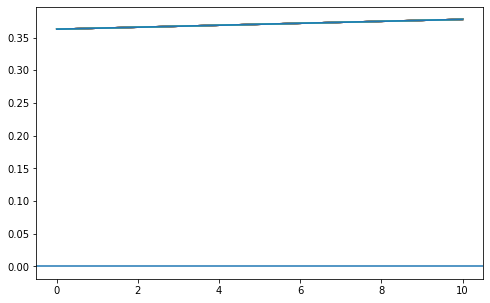

In [296]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

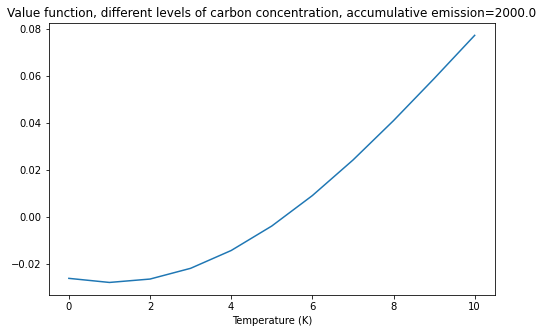

In [297]:
ii = -1
plt.plot(T_grid, v0[:, -1, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

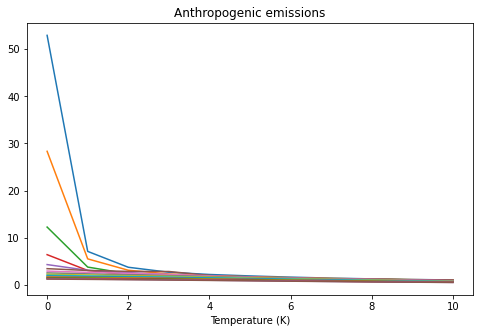

In [298]:
plt.plot(T_grid, Ca[:, :, 6])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

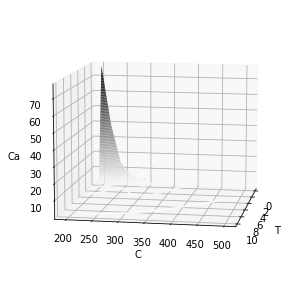

In [299]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [300]:
t_max = 600.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + min(T_grid)
C_0 = 275.5
F_0 = 0. #(870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo

# T_0 = To + 1.1
# C_0 = 417
# F_0 = (870 - 580) / 2.13

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To + min(T_grid))
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


In [301]:
min(T_grid), hist

(1e-08,
 array([[ 282.87000001,  275.5       ,    0.        ],
        [ 282.87000001,  280.94778547,    5.91715148],
        [ 282.88132383,  285.55397927,   11.06965055],
        ...,
        [ 286.48728752,  251.07789319, 1284.36647236],
        [ 286.43550894,  251.02319756, 1285.99642805],
        [ 286.38351981,  251.01632599, 1287.63682796]]))

Text(0.5, 1.0, '$S_a$')

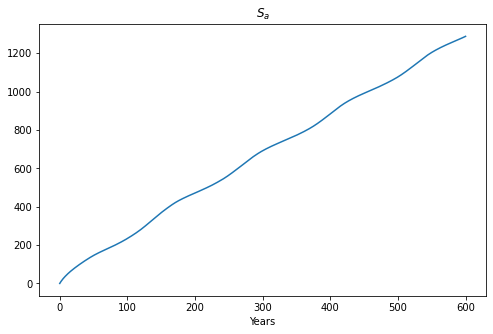

In [302]:
plt.plot(years[:], hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

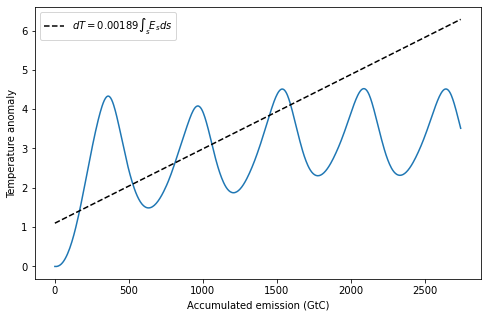

In [303]:
plt.plot(hist[:, 2] * 2.13, hist[:, 0] - To)
plt.plot(hist[:, 2] * 2.13, 1.1 +  (hist[:, 2] - hist[0, 2]) * 2.13 * 0.00189, 
         linestyle="dashed", color="black", label="$dT = 0.00189 \int_s E_s ds$")
plt.xlabel("Accumulated emission (GtC)")
plt.ylabel("Temperature anomaly")
plt.legend()
# plt.savefig("T_F_35.pdf")

In [304]:
e_hist

array([5.91715148, 5.91715148, 5.15249906, 4.85721789, 4.57925202,
       4.32509902, 4.09877277, 3.9105111 , 3.78619721, 3.66821294,
       3.55670572, 3.45173541, 3.35328572, 3.26127486, 3.17554976,
       3.09586627, 3.02200943, 2.96183592, 2.90521417, 2.85518653,
       2.80879033, 2.76539732, 2.72488552, 2.68712771, 2.65199325,
       2.61934963, 2.58906394, 2.56100416, 2.53488267, 2.50851104,
       2.4837786 , 2.46020092, 2.4374056 , 2.41579238, 2.39520666,
       2.37551028, 2.35658978, 2.34153219, 2.32462229, 2.30153339,
       2.27776217, 2.25320524, 2.22779152, 2.20148202, 2.17426953,
       2.14617828, 2.11726345, 2.08761069, 2.05733534, 2.02658165,
       1.98478887, 1.93342028, 1.89415339, 1.86462585, 1.83684978,
       1.81079312, 1.78641219, 1.76365306, 1.74245303, 1.72274205,
       1.70455994, 1.68853056, 1.67374485, 1.66011216, 1.64754143,
       1.63594234, 1.62522628, 1.61530732, 1.60610299, 1.59753503,
       1.58952997, 1.58201968, 1.59045942, 1.60340013, 1.61649

(-0.1, 13.07727508716027)

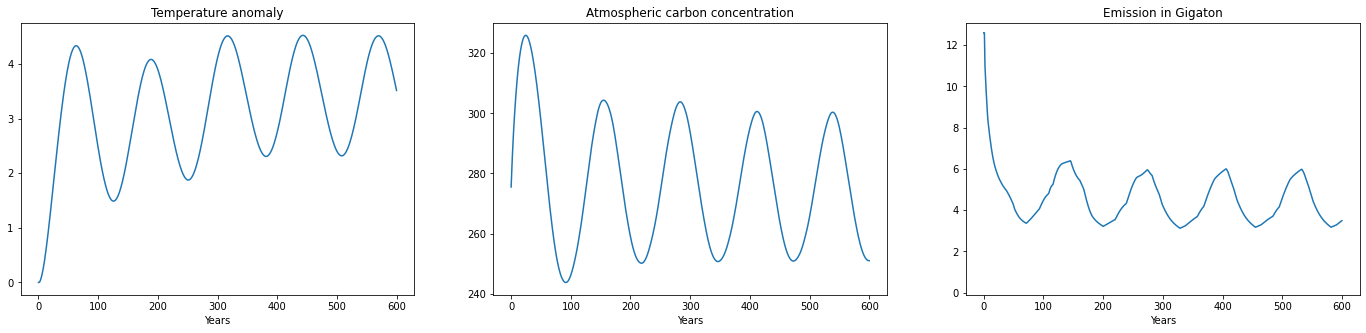

In [307]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist * 2.13)
plt.xlabel("Years")
plt.title("Emission in Gigaton")
plt.ylim(-0.1)
# plt.savefig(f"T_C_E_{cearth}_{tauc}.pdf")

In [308]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
    "Ca": Ca,
}

pickle.dump(res, open(f"./data_{cearth}_{tauc}", "wb"))

In [133]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

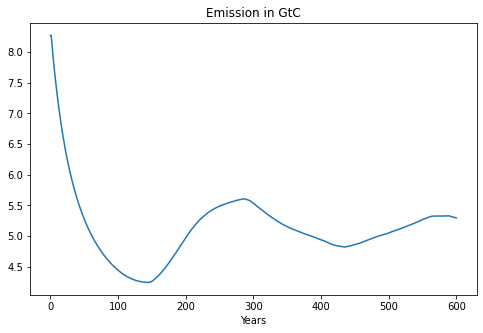

In [134]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [35]:
# df = pd.DataFrame({
#     'Years': years,
#     'Et(Gigaton)': Et,
#                   })

# df.to_csv("Et.csv", index=False)